# Title Deduplication 
Here we are going to perform an algorithm of deduplication - a method that helps to find titles that describe same entities. Deduplication will be held in two steps:
- title normalization
- calculating distance between normed titles
- building edges based on those distances
- finding components in the graph

In our case we will try to deduplicate food titles from different grocery stores (in Russian)

In [1]:
import numpy as np
import pandas as pd

import random
import re
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

### Step 1. Normalization
We are going to apply quite simplie normalization tricks:
- lowercase
- remove whitespaces to convert `0.5 l` to `0.5l`. It will help to consider weights and volumes as one token
- normalize decimals delimeter: `0,25g` -> `0.25g`
- remove commas
- tokenize - split by whitespaces, the tokens are words
- remove stopwords
- stem words
- sort words; although it won't affect the distance calculation, it would be nice to have a standart word order in a normalized form
- join tokens with a single whitespace

In [2]:
rus_stopwords = set(stopwords.words('russian'))
rus_stopwords.remove('уже') # for the sake of Уже Готово
rus_stemmer = SnowballStemmer('russian')

In [3]:
def preprocess_title(title):
    res = title.lower()
    res = re.sub(r'([0-9]+)\s+(g|kg|l|ml|л|г|грамм|кг|килограмм|литр|литров)\b', '\\1\\2', res)
    res = re.sub(r'([0-9]+),([0-9]+\w*)\b', '\\1.\\2', res)
    res = re.sub(r',', '', res)
    return res

def tokenize_title(title, swords, stemmer=None):
    res = preprocess_title(title)
    # res = word_tokenize(res, 'russian')
    res = res.split()
    res = [word for word in res if word not in swords]
    if stemmer != None:
        res = [stemmer.stem(word) for word in res]
    return res

def normalize_title(title, swords, stemmer=None):
    tokens = tokenize_title(title, swords, stemmer)
    return ' '.join(sorted(tokens))

In [4]:
x = 'Салат Коул-Слоу постный, Уже Готово , 200 г'
normalize_title(x, rus_stopwords, rus_stemmer)

'200г готов коул-сло постн салат уж'

### Step 2. The distance
We are going to use the `fuzzywuzzy` module to calculate Levenshtein distance between tokens in normalized form. 
The thing we are going to imply - similarity in groups of titles that represent the same is much higher than between members of different groups.

In [5]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [6]:
x = 'Салат Коул-Слоу постный, Уже Готово , 200 г'
y = 'Салат Коул Слоу упак'
fuzz.token_set_ratio(
    normalize_title(x, rus_stopwords, rus_stemmer),
    normalize_title(y, rus_stopwords, rus_stemmer)
)

85

Quite close. Let's see what happens to titles from the email

In [7]:
testcases = [
    'Кисломолочный напиток Актимель ежевично-черничный 100 г',
    'Напиток Данон Актимель черника/ежевика 2,5% 6*0,1л Россия',
    'Гель для душа Роскошная мягкость Черная орхидея Palmolive, 250 мл',
    'Гель Palmolive Naturals д/душа Роскошная мягкость Черная орхидея 250мл Италия',
    'Гель для душа Palmolive "Черная орхидея" 250 мл',
    'Корм Whiskas говядина/кролик канапе новогодний 85г Россия'    
]

In [8]:
normed_testcases = [normalize_title(x, rus_stopwords, rus_stemmer) for x in testcases]

In [9]:
similarity_matrix = np.zeros((len(testcases), len(testcases)))

In [10]:
for i, x in enumerate(normed_testcases):
    for j, y in enumerate(normed_testcases):
        similarity_matrix[i, j] = fuzz.token_set_ratio(x, y)

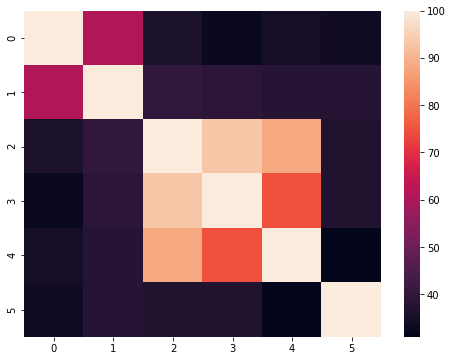

In [11]:
plt.figure(figsize=(8,6))
sn.heatmap(similarity_matrix)
plt.show()

As we see from from diagonal blocks the result is correct: `[[1, 2], [3, 4, 5], [6]]`.

Let's get those groups explicitly in two steps:
- build a graph on titles adding an edge if two titles are close enough
- find components in the graph

In [12]:
def add_ids_to_titles(title_list):
    return {i: title for i, title in enumerate(title_list)}


def build_graph(id_list, id_to_title_map, distance_func, thold):
    graph = {}
    for i, title_id in enumerate(id_list):
        graph[title_id] = set()
        title = id_to_title_map[title_id]
        for candidate_title_id in id_list:
            candidate_title = id_to_title_map[candidate_title_id]
            if title_id != candidate_title_id and distance_func(title, candidate_title) > thold:
                graph[title_id].add(candidate_title_id)
    return graph


def traverse_component(node, graph):
    component_nodes = set()
    queue = [node]
    while len(queue):
        cur_node = queue[0]
        component_nodes.add(cur_node)
        queue = queue[1:]
        for next_node in graph[cur_node]:
            if next_node not in component_nodes:
                queue.append(next_node)
    return sorted(list(component_nodes))
    

def build_components_list(graph):
    nodes_seen = set()
    components = []
    for node in graph:
        if node not in nodes_seen:
            component = traverse_component(node, graph)
            components.append(component)
            nodes_seen = nodes_seen.union(component)
    return components


def group_titles(titles, distance_function=fuzz.token_set_ratio, thold=60):
    normed_titles = [normalize_title(x, rus_stopwords, rus_stemmer) for x in titles]
    id_to_title_map = add_ids_to_titles(normed_titles)
    title_ids = list(id_to_title_map.keys())
    graph = build_graph(title_ids, id_to_title_map, distance_function, thold)
    grouped_ids = build_components_list(graph)
    res = []
    for group in grouped_ids:
        res.append([titles[x] for x in group])
    return res

In [13]:
for group in group_titles(testcases):
    for title in group:
        print(title)
    print('---')

Кисломолочный напиток Актимель ежевично-черничный 100 г
Напиток Данон Актимель черника/ежевика 2,5% 6*0,1л Россия
---
Гель для душа Роскошная мягкость Черная орхидея Palmolive, 250 мл
Гель Palmolive Naturals д/душа Роскошная мягкость Черная орхидея 250мл Италия
Гель для душа Palmolive "Черная орхидея" 250 мл
---
Корм Whiskas говядина/кролик канапе новогодний 85г Россия
---


Now we see the desired result. Good. Let's move to next and final part.

## Validation on full data (already groupped)

In [14]:
with open('titles.json') as json_file:
    data = json.load(json_file)

#### Here we will plot some statistics - sizes of groups and most common tokens (before and after normalization)

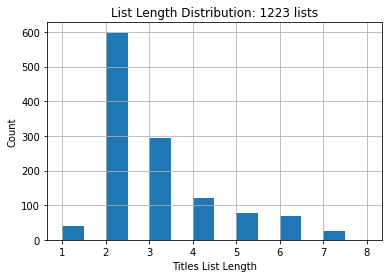

In [15]:
lengths = list(map(len, data))
x_axis = np.arange(1, max(lengths) + 2)
plt.hist(lengths, width=0.5, bins=x_axis)
plt.grid()
plt.xticks(x_axis)
plt.xlabel('Titles List Length')
plt.ylabel('Count')
plt.title('List Length Distribution: {} lists'.format(len(data)))
plt.show()

In [16]:
sum(lengths)

3580

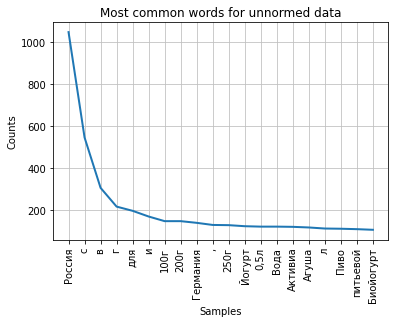

In [17]:
merged_data = sum(data, [])
merged_data = sum([title.split() for title in merged_data], [])
freq = nltk.FreqDist(merged_data)
plt.title('Most common words for unnormed data')
freq.plot(20, cumulative=False)
plt.show()

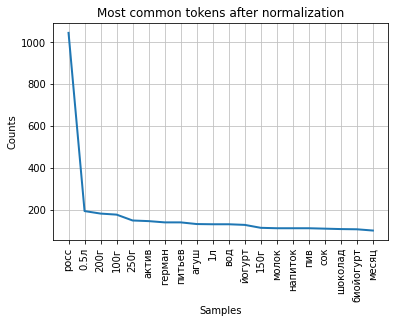

In [18]:
processed_titles = sum([tokenize_title(x, rus_stopwords, rus_stemmer) for x in sum(data, [])], [])
freq = nltk.FreqDist(processed_titles)
plt.title('Most common tokens after normalization')
freq.plot(20, cumulative=False)
plt.show()

We are going to estimate ingroup and outgroup similarities.

For ingroups we will implement a straighforward calculation for every pair in a group. 
As for outgroup similarity to decrease computational costs we will use **negative sampling** - for each title we will sample 10 other titles and calculate similarities with those, that do not belong to the same group as the target title.

In [19]:
preprocessed_data = []
for i, group in enumerate(data):
    for title in group:
        normed_title = ' '.join(tokenize_title(title, rus_stopwords, rus_stemmer))
        preprocessed_data.append([normed_title, i])

In [20]:
ingroup_distance = []
for group in data:
    for i, x in enumerate(group):
        for y in group[i+1:]:
            ingroup_distance.append(
                fuzz.token_set_ratio(
                    ' '.join(tokenize_title(x, rus_stopwords, rus_stemmer)),
                    ' '.join(tokenize_title(y, rus_stopwords, rus_stemmer))
                )
            )

In [21]:
outgroup_distance = []
for x in preprocessed_data:
    for y in random.sample(preprocessed_data, 10):
        if x[1] != y[1]:
            outgroup_distance.append(fuzz.token_set_ratio(x[0], y[0]))

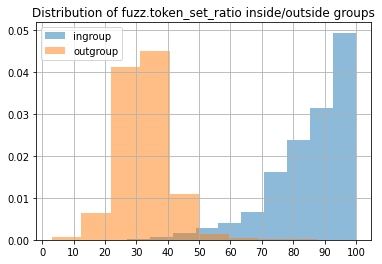

In [22]:
plt.title('Distribution of fuzz.token_set_ratio inside/outside groups')
plt.hist(ingroup_distance, label='ingroup', alpha=0.5, density=True)
plt.hist(outgroup_distance, label='outgroup', alpha=0.5, density=True)
plt.legend(loc=0)
plt.grid()
plt.xticks(np.arange(0, 110, 10))
plt.show()

This plot proves our point about ingroup and outgroup similarities and suggests that our approach was valid. However, there is still space to improve, as we see the overlapping parts of distributions.

In [23]:
titles = []
for group in data:
    titles += group

In [24]:
%%time
title_groups = group_titles(titles[:100], thold=66)

for group in title_groups:
    for title in group:
        print(title)
    print('---')

Баклажаны с орехами упак
Винегрет упак
Салат FreshSecret Винегрет 600г
Винегрет с ароматным подсолнечным маслом, Уже Готово , 350 г
Морковь по-корейски
Морковь по-корейски упак
Салат FreshSecret Морковь по-корейски, 250г
Морковь по-корейски, Уже Готово , 250 г
Оладьи из кабачков упак
Оладьи из кабачков, Уже Готово , 250 г
Салат Коул Слоу упак
Салат Коул-Слоу постный, Уже Готово , 200 г
Салат Мимоза с горбушей
Салат Мимоза по-домашнему упак
Салат СлавянСалат премиум Мимоза, 320г
Салат Мимоза с семгой от бренд-шефа АВ
Салат Оливье упак
Салат Оливье с мясом от бренд-шефа АВ
Салат СлавянСалат Свекольный с чесноком 400г
Салат свекольный с черносливом и грецкими орехами упак
Салат свекла с черносливом, Уже Готово , 250 г
Салат СлавянСалат Столичный 1кг
Салат Столичный упак
Салат Столичный , Городской супермаркет , Россия
Салат Славянсалат Сырный 400г
Салат Сырный упак
Салат сырный, Уже Готово , 200 г
Салат Цезарь с курицей
Салат Цезарь упак
Сельдь под шубой
Сельдь под шубой упак
Салат Славян

Slightly far from perfect